#  Minimizing the amount of correlations
## Nicolas Quesada

In a [paper](https://doi.org/10.1103/PhysRevA.88.044301) by Jiang, Lang, and Caves the authors show that if one has two qumodes states $\left|\psi \right\rangle$ and $\left|\phi \right\rangle$ and a beamsplitter $\text{BS}(\theta)$ then the only way no entanglement is generated when the beamsplitter acts on the product of the two states 

$\left|\Psi  \right\rangle = \text{BS}(\theta) \ \left|\psi \right\rangle \otimes \left|\phi \right\rangle$

is if the states $\left|\psi \right\rangle$ and $\left|\phi \right\rangle$ are squeezed states along the same quadrature and by the same amount.

Now imagine the following task: Given an input state $\left|\psi \right\rangle$, which is not necessarily a squeezed state, what is the optimal state $\left|\phi \right\rangle$ that when sent into a given beamsplitter $\text{BS}(\theta)$ together with $\left|\psi \right\rangle$ will generate the least amount of entanglement.

In our [paper](https://arxiv.org/abs/1805.06868) we showed that if $\theta \ll 1$ the optimal state $\left|\phi \right\rangle$, for any input state $\left|\psi \right\rangle$, is always a squeezed state.
We furthermore conjectured that this holds for any value of $\theta$.
Here we numerically explore this question by performing numerical minimization over $\left|\phi \right\rangle$ to find the state that minimizes the entanglement between the two modes.

In [1]:
# Import basic utility functions
import numpy as np
from scipy.linalg import expm
import tensorflow as tf

/home/nicolas/anaconda2/envs/covarianceproject/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import strawberryfields
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.backends.tfbackend.ops import partial_trace

In [3]:
# Set the cutoff dimension
cutoff = 30

In [4]:
# Given state |\psi>, an equal superposition of |0> and |1>
psi = np.zeros([cutoff],dtype=np.complex128)
psi[0] = 1.0
psi[1] = 1.0
psi /= np.linalg.norm(psi)

In [5]:
# Initial random guess for |\phi>
phi = np.random.random(size=[cutoff]) + 1j*np.random.random(size=[cutoff])
phi[10:] = 0.
phi /= np.linalg.norm(phi)

In [6]:
# Define a creation operator
a = np.diag(np.sqrt(np.arange(1,cutoff)), k=1)

In [7]:
# Check that it gives the number operator when one does a^\dagger a
n_opt = a.T @ a
np.diag(n_opt)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [8]:
# Define quadrature operators
x = a + a.T
p = -1j*(a-a.T)

In [9]:
def recenter(initket):
    """ Given a ket expressed as a numpy array it 
    calculates the displacement \alpha = <initket|a|initket>
    and the applies a displacement in phase space
    so that the ket returned has zero displacement
    """
    alpha = np.dot(np.conj(initket),np.dot(a,initket))
    dalpha = expm(np.conj(alpha)*a-alpha*a.T)
    initket1 = np.dot(dalpha,initket)
    alpha1 = np.dot(np.conj(initket1),np.dot(a,initket1))
    return initket1

In [10]:
# Check expectation value of creation operator on |\psi>
psi.conj().T @ a @ psi

(0.4999999999999999+0j)

In [11]:
# Make sure the initial kets have zero displacement
psi = recenter(psi)
phi = recenter(phi)

In [12]:
# Check psi
psi.conj().T @ a @ psi

(1.8041124150158794e-16+0j)

In [13]:
# Check phi
phi.conj().T @ a @ phi

(2.1271526653987571e-07+1.137852105592696e-08j)

In [14]:
# Setup strawberryfields
eng, q = sf.Engine(2)

psi = tf.cast(psi, tf.complex64)
phi_var = tf.cast(tf.Variable(phi.real),tf.complex64) + 1j*tf.cast(tf.Variable(phi.imag), tf.complex64)

ket = tf.tensordot(psi, phi_var, axes=0)

with eng:
    Ket(ket) | q
    BSgate(np.pi/4, 0) | q
    
state = eng.run('tf',cutoff_dim=cutoff, eval=False, modes=[1])

In [15]:
# We will only keep track of the state in register 1

In [16]:
state.is_pure

False

In [17]:
# Define the density matrix of mode B (register 1)
rhoB = state.dm()

In [18]:
penalty_strength = 10

In [19]:
# The cost function contains the purity of the reduced density matrix
# and an extra penaly that forces the optimized state to have zero displacement
# Finally, we divide by the tr(rhoB)**2 so that the state is always normalized

cost = tf.cast(tf.real((tf.trace(rhoB @ rhoB)
                        -penalty_strength*tf.trace(rhoB @ x)**2
                        -penalty_strength*tf.trace(rhoB @ p)**2)/(tf.trace(rhoB))**2
                      ), tf.float64)

In [20]:
# Set up optimization
optimizer = tf.train.AdamOptimizer()
minimize_op = optimizer.minimize(-cost)

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
# Import plotting
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
x = np.arange(-5, 5, 0.01)
p = np.arange(-5, 5, 0.01)

In [24]:
# Wigner function for plotting purposes
# This code is taken from qutip.org

def wigner(rho, xvec, pvec):
    # Modified from qutip.org
    Q, P = np.meshgrid(xvec, pvec)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

0 0.6098433136940002
50 0.7205178141593933
100 0.7992028594017029
150 0.8546816110610962
200 0.8947429656982422
250 0.9071398973464966
300 0.9105072617530823
350 0.9117374420166016
400 0.9121131300926208
450 0.91221022605896
500 0.9122315049171448
550 0.9122356176376343
600 0.9122363328933716
650 0.9122362732887268
700 0.9122365117073059
750 0.9122364521026611
800 0.9122365117073059
850 0.9122363328933716
900 0.9122363924980164
950 0.9122365117073059
1000 0.9122364521026611
1050 0.9122365117073059
1100 0.9122365117073059
1150 0.9122365117073059
1200 0.9122365117073059


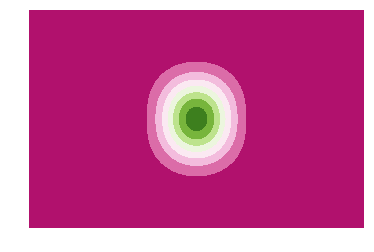

In [25]:
# Now do the optimization and plot the wigner function of the optimal state
# and print the values of the cost function
# It also saves snapshots of the wigner function every 50 iterations
reps = 1201

cost_progress = []

for i in range(reps):

    [_, cost_val, ket_val] = sess.run([minimize_op, cost, phi_var])
    # Stores fidelity at each step
    cost_progress.append(cost_val)

    # Prints progress
    if i % 50 == 0:
        print(i, cost_val)
        rho = np.outer(ket_val, ket_val.conj().T)

        X, P, W = wigner(rho, x, p)
        plt.contourf(X, P, np.round(W,3), cmap="PiYG")
        plt.axis('off')
        plt.savefig('./sfwigner'+str(i))
        

In [26]:
# We see that the optimal state is indeed a (mildly) squeezed state

<Container object of 30 artists>

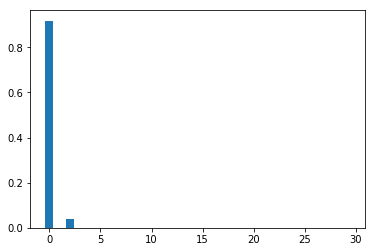

In [27]:
plt.bar(np.arange(cutoff), height=np.abs(ket_val)**2)

In [36]:
nbar = ((ket_val.conj()).T @ n_opt @ ket_val).real
print("mean number of photons =",nbar)
print("squeezing parameter =",np.arcsinh(np.sqrt(nbar)))

mean number of photons = 0.08004363215821492
squeezing parameter = 0.27927531723173893
